### **导入库**

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

In [194]:
# 过滤警告
import warnings
warnings.filterwarnings("ignore")

# plt中文显示问题
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负

# sns中文显示
sns.set(font="simhei")

### **导入数据**

In [195]:
# 导入数据
retail =  pd.read_csv('拼多多项目-RFM原始数据Python.csv',encoding='GBK')
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,所在省市,CustomerID,金额
0,537899,22328,ROUND SNACK BOXES SET OF 4 FRUITS,1488,01-12-2010 08:26,2.55,安徽,17850.0,3794.4
1,579498,23084,RABBIT NIGHT LIGHT,2040,01-12-2010 08:26,1.79,安徽,17850.0,3651.6
2,572869,23084,RABBIT NIGHT LIGHT,960,01-12-2010 08:26,1.79,安徽,17850.0,1718.4


### **查看数据**

In [196]:
print('数据形状：')
print(retail.shape)
print('-'*50)
print('数据描述性统计：')
print(retail.describe())
print('-'*50)
print('数据信息：')
print(retail.info())

数据形状：
(541909, 9)
--------------------------------------------------
数据描述性统计：
            Quantity      UnitPrice     CustomerID             金额
count  541909.000000  541909.000000  406829.000000  541909.000000
mean        9.552250       4.611114   15287.690570      17.987795
std       218.081158      96.759853    1713.600303     378.810824
min    -80995.000000  -11062.060000   12346.000000 -168469.600000
25%         1.000000       1.250000   13953.000000       3.400000
50%         3.000000       2.080000   15152.000000       9.750000
75%        10.000000       4.130000   16791.000000      17.400000
max     80995.000000   38970.000000   18287.000000  168469.600000
--------------------------------------------------
数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-nul

### **缺失值处理**

In [197]:
# 查看缺失值
retail.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
所在省市           0.000000
CustomerID     0.249267
金额             0.000000
dtype: float64

In [198]:
# 对于占比较小的缺失值可以选择删除
retail = retail.dropna()

### **数据格式规整**

In [199]:
# 将客户ID转换为字符串类型
retail['CustomerID'] = retail['CustomerID'].astype(str)
# 将发票日期转换为时间类型
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

### **构建聚类特征**

In [200]:
# 添加新特征——交易总额
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
# 求每个用户总消费额
RFM_M = retail.groupby('CustomerID')['Amount'].sum().reset_index()
RFM_M.head(3)

,CustomerID,Amount
0,12346.0,51.00
1,12347.0,4626.49
2,12348.0,941.31


In [201]:
# 添加新特征——购买频率
RFM_F = retail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
RFM_F.head(3)

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31


In [202]:
# 添加新特征——最近消费日期
# 计算最大交易日期得出最后交易日期
last_date = max(retail['InvoiceDate'])
# 计算最后交易日期和当前交易日期之间的差异
retail['Diff'] = last_date - retail['InvoiceDate']
# 计算最后交易日期
RFM_R = retail.groupby('CustomerID')['Diff'].min().reset_index()
RFM_R['Diff'] = RFM_R['Diff'].dt.days
RFM_R.head(3)

,CustomerID,Diff
0,12346.0,326
1,12347.0,40
2,12348.0,76


In [203]:
# 将特征组合成新的RFM数据集
RFM = pd.merge(RFM_R,RFM_F,on='CustomerID',how='inner')
RFM = pd.merge(RFM,RFM_M,on='CustomerID',how='inner')
RFM.columns = ['CustomerID', 'R','F','M']
RFM

,CustomerID,R,F,M
0,12346.0,326,2,51.00
1,12347.0,40,182,4626.49
2,12348.0,76,31,941.31
3,12349.0,19,73,30.66
4,12350.0,311,17,353.60
...,...,...,...,...
4367,18280.0,160,10,177.00
4368,18281.0,4,7,70.00
4369,18282.0,93,13,401.55
4370,18283.0,10,756,8234.51


### **探索性数据分析**

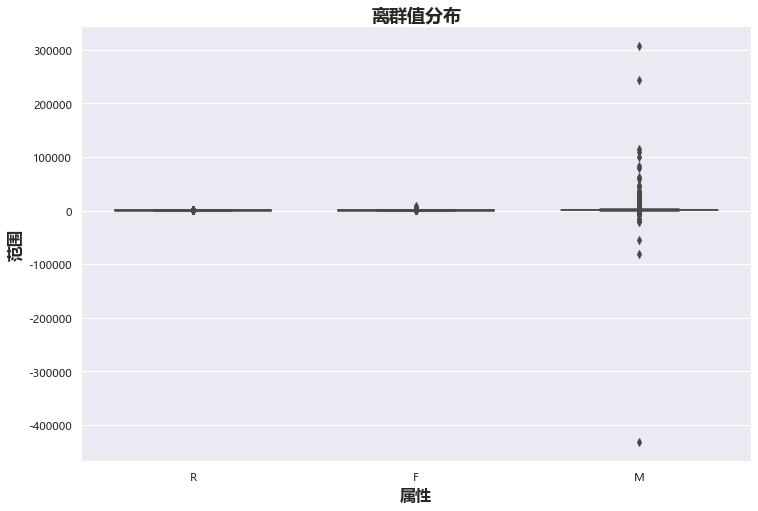

In [204]:
sns.set_style('darkgrid')
sns.set(font="Microsoft Yahei")
plt.rcParams['figure.figsize'] = [12,8]
sns.boxplot(data=RFM[['R','F','M']],orient='v',
            palette='Set1',
            saturation=1,
            whis=1.5,
            width=0.7
            )
plt.xlabel('属性',fontsize = 16,fontweight = 'bold')
plt.ylabel('范围',fontsize = 16,fontweight = 'bold')
plt.title('离群值分布',fontsize = 18,fontweight = 'bold');

### **离群值处理**

In [205]:
"""
异常值/离群值检验有三种方法，分别是：
1.描述性统计方法查看
2.三倍标准差法过滤
3.借助箱型图，以上四分位±1.5倍四分位为边界判断

另外需要注意的是，在实际业务中，异常值需要根据业务
情况进行处理。对于本数据集的超大数据可能代表着高消费客户，
所以不能轻易删除。
"""
# 下面为其中一种处理方式


'\n异常值/离群值检验有三种方法，分别是：\n1.描述性统计方法查看\n2.三倍标准差法过滤\n3.借助箱型图，以上四分位±1.5倍四分位为边界判断\n\n另外需要注意的是，在实际业务中，异常值需要根据业务\n情况进行处理。对于本数据集的超大数据可能代表着高消费客户，\n所以不能轻易删除。\n'

In [206]:
# 移除M列离群值
Q1 = RFM.M.quantile(0.05)
Q2 = RFM.M.quantile(0.95)
IQR = Q2-Q1
RFM = RFM[(RFM.M>=Q1-1.5*IQR)&(RFM.M<=Q2+1.5*IQR)]

# 移除R列离群值
Q1 = RFM.R.quantile(0.05)
Q2 = RFM.R.quantile(0.95)
IQR = Q2-Q1
RFM = RFM[(RFM.R>=Q1-1.5*IQR)&(RFM.R<=Q2+1.5*IQR)]

# 移除F列离群值
Q1 = RFM.F.quantile(0.05)
Q2 = RFM.F.quantile(0.95)
IQR = Q2-Q1
RFM = RFM[(RFM.F>=Q1-1.5*IQR)&(RFM.F<=Q2+1.5*IQR)]

### **模型构建**

In [207]:
# 标准化
train = RFM[['R','F','M']]
# 这里注意：数据标准化处理很有必要，去除量纲带来的影响
train = StandardScaler().fit_transform(train)
train

array([[ 1.98597938, -0.74474135, -0.5346345 ],
       [-0.54529644,  1.01753679,  1.7841037 ],
       [-0.22667431, -0.46081876, -0.08344877],
       ...,
       [-0.86391857, -0.69578918, -0.5250058 ],
       [-0.07621386, -0.63704657, -0.35698497],
       [-0.89932103, -0.07899183, -0.32949249]])

In [208]:
model = KMeans(algorithm='lloyd',
               n_clusters=8,
               max_iter=1000,
               random_state=2022,
               verbose=True
               )
model.fit(train).cluster_centers_

Initialization complete
Iteration 0, inertia 2558.8318135222194.
Iteration 1, inertia 2192.0507372155557.
Iteration 2, inertia 2140.444900729769.
Iteration 3, inertia 2115.9437208249706.
Iteration 4, inertia 2084.0510050211906.
Iteration 5, inertia 2059.5045104958394.
Iteration 6, inertia 2039.6441136403685.
Iteration 7, inertia 2025.7672283955337.
Iteration 8, inertia 2012.2944321641153.
Iteration 9, inertia 1993.0458421746744.
Iteration 10, inertia 1981.5862094336676.
Iteration 11, inertia 1976.7713150155064.
Iteration 12, inertia 1973.7927993933063.
Iteration 13, inertia 1971.99320439282.
Iteration 14, inertia 1971.0187441732385.
Iteration 15, inertia 1969.9096997346953.
Iteration 16, inertia 1969.544359466731.
Iteration 17, inertia 1969.2068127541534.
Iteration 18, inertia 1968.909847678264.
Iteration 19, inertia 1968.2134314007897.
Iteration 20, inertia 1967.8379839050988.
Iteration 21, inertia 1967.4362335125504.
Iteration 22, inertia 1966.7121719940237.
Iteration 23, inertia 196

array([[-0.55640408,  0.55658688,  0.29199215],
       [ 0.48642461, -0.47415297, -0.36023497],
       [-0.71122003,  4.37317994,  3.59988196],
       [-0.54736873, -0.38738486, -0.43113218],
       [ 1.63109091, -0.51366547, -0.29432556],
       [-0.63006195,  2.05953453,  1.36032362],
       [-0.30530861,  0.83566065,  3.98459184],
       [ 4.27841151, -0.5950293 ,  0.17651814]])

### **模型解释**

In [209]:
# 查看聚类类别标签
model.labels_

array([4, 5, 3, ..., 3, 3, 3])

In [210]:
print(f'第一类用户数量：{(model.labels_==0).sum()}')
print(f'第二类用户数量：{(model.labels_==1).sum()}')
print(f'第三类用户数量：{(model.labels_==2).sum()}')
print(f'第四类用户数量：{(model.labels_==3).sum()}')
print(f'第五类用户数量：{(model.labels_==4).sum()}')
print(f'第六类用户数量：{(model.labels_==5).sum()}')
print(f'第七类用户数量：{(model.labels_==6).sum()}')
print(f'第八类用户数量：{(model.labels_==7).sum()}')

第一类用户数量：698
第二类用户数量：815
第三类用户数量：87
第四类用户数量：1734
第五类用户数量：543
第六类用户数量：265
第七类用户数量：78
第八类用户数量：72


In [211]:
# 查看各类用户比重
R1 = pd.Series(model.labels_).value_counts()
R2 = pd.DataFrame(model.cluster_centers_)
Cluster_8 = pd.concat([R1, R2],axis=1)
Cluster_8.columns = ['数量','R','F','M']
Cluster_8['占比'] = round(Cluster_8['数量']/RFM.shape[0],4)
#Cluster_8 = pd.merge(Cluster_8,df,left_index=True,right_index=True) 
Cluster_8

,数量,R,F,M,占比
3,1734,-0.547369,-0.387385,-0.431132,0.4040
1,815,0.486425,-0.474153,-0.360235,0.1899
0,698,-0.556404,0.556587,0.291992,0.1626
4,543,1.631091,-0.513665,-0.294326,0.1265
5,265,-0.630062,2.059535,1.360324,0.0617
2,87,-0.711220,4.373180,3.599882,0.0203
6,78,-0.305309,0.835661,3.984592,0.0182
7,72,4.278412,-0.595029,0.176518,0.0168


In [212]:
"""
根据上表结果，确定聚类类别与用户类别对应关系，进行手动分类;
2---->HHH:重要价值客户
1---->HHL:一般价值客户
6---->HLH:重要发展客户
3---->HLL:一般发展客户
5---->LHH:重要保持客户
0---->LHL:一般保持客户
7---->LLH:重要挽留客户
4---->LLL:一般挽留客户
"""

Cat_of_Customer = { 2:'重要价值客户',
                    1:'一般价值客户',
                    6:"重要发展客户",
                    3:'一般发展客户',
                    5:'重要保持客户',
                    0:'一般保持客户',
                    7:'重要挽留客户',
                    4:'一般挽留客户'}

df = pd.DataFrame.from_dict(Cat_of_Customer, orient='index')
df = df.reset_index()
df.columns = ['聚类类别','用户分层']
df

,聚类类别,用户分层
0,2,重要价值客户
1,1,一般价值客户
2,6,重要发展客户
3,3,一般发展客户
4,5,重要保持客户
5,0,一般保持客户
6,7,重要挽留客户
7,4,一般挽留客户


In [213]:
Cluster_8 = pd.merge(Cluster_8,df,left_index=True,right_index=True) 
Cluster_8

,数量,R,F,M,占比,聚类类别,用户分层
3,1734,-0.547369,-0.387385,-0.431132,0.4040,3,一般发展客户
1,815,0.486425,-0.474153,-0.360235,0.1899,1,一般价值客户
0,698,-0.556404,0.556587,0.291992,0.1626,2,重要价值客户
4,543,1.631091,-0.513665,-0.294326,0.1265,5,重要保持客户
5,265,-0.630062,2.059535,1.360324,0.0617,0,一般保持客户
2,87,-0.711220,4.373180,3.599882,0.0203,6,重要发展客户
6,78,-0.305309,0.835661,3.984592,0.0182,7,重要挽留客户
7,72,4.278412,-0.595029,0.176518,0.0168,4,一般挽留客户


In [214]:
# 然后将聚类结果传入RFM表中，让结果更直观
RFM_rfm = pd.merge(RFM,pd.DataFrame(model.labels_,columns=['聚类类别']),left_index=True,right_index=True)
# RFM = pd.merge(RFM,df,left_on=None, right_on=None, left_index=False, right_index=False)
RFM_rfm

,CustomerID,R,F,M,聚类类别
0,12346.0,326,2,51.00,4
1,12347.0,40,182,4626.49,5
2,12348.0,76,31,941.31,3
3,12349.0,19,73,30.66,3
4,12350.0,311,17,353.60,4
...,...,...,...,...,...
4287,18174.0,301,1,19.80,3
4288,18176.0,354,33,1355.10,1
4289,18177.0,121,75,803.72,3
4290,18178.0,114,99,2042.39,3


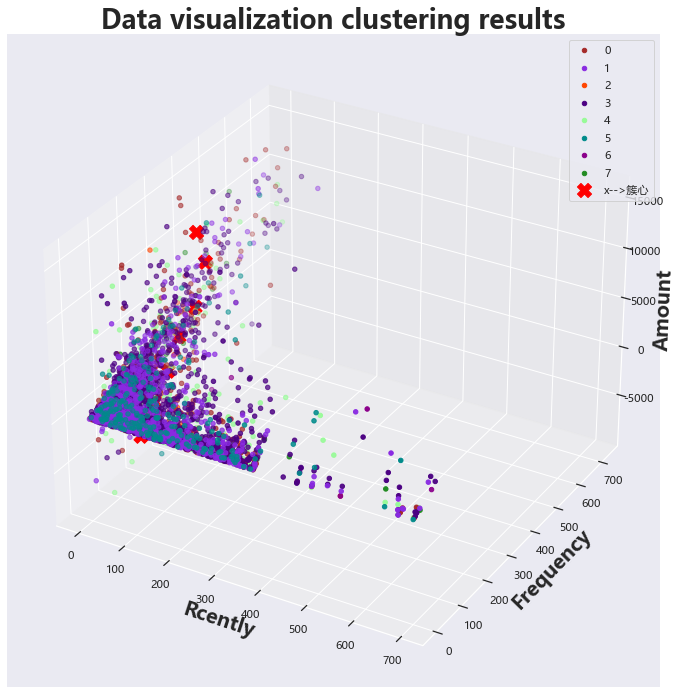

In [215]:
# 可视化聚类结果
# 先使用为标准化的数据进行试验
# 可见为标准化处理的聚类效果极其混乱，很多数据分类不明确
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
model_1 = KMeans(algorithm='lloyd',
               n_clusters=8,
               max_iter=1000,
               random_state=2022).fit(RFM[['R','F','M']])
fig = plt.figure(figsize=(12,12)) # 创建一个画布figure，然后在这个画布上加各种元素。
ax = fig.add_subplot(1,1,1,projection='3d')

color = ['#A52A2A','#8A2BE2','#FF4500','#4B0082','#98FB98','#008B8B','#8B008B','#228B22']
centers = model_1.cluster_centers_
for i,j in zip(range(0,8),color): 
    RFM_C = RFM_rfm[RFM_rfm['聚类类别']==i]
    ax.scatter(RFM_C['R'], RFM_C['F'], RFM_C['M'],color=j,label=i)
    ax.set_xlabel('Rcently',fontsize=20,fontweight='bold')
    ax.set_ylabel('Frequency',fontsize=20,fontweight='bold')
    ax.set_zlabel('Amount',fontsize=20,fontweight='bold')
    ax.set_title('Data visualization clustering results',fontsize=26,fontweight='bold')
    ax.legend();
  
# 画出簇心
ax.scatter(centers[:, 0], centers[:, 1],centers[:, 2], marker='X',
            c="red", alpha=1, s=200,label='x-->簇心')
ax.legend();

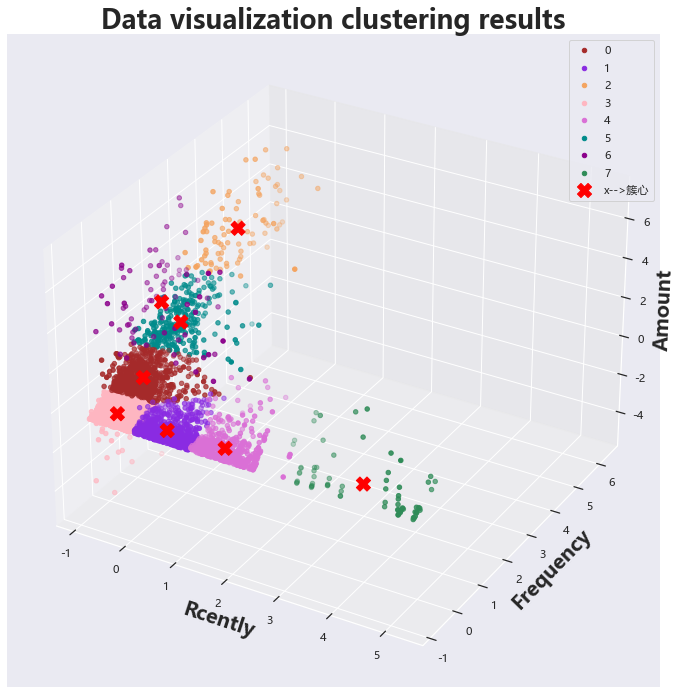

In [216]:
# 可视化聚类结果————对输入数据标准化处理，去除量纲带来的影响
# 效果相比未处理提升了不少，聚类效果比较明显
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1,projection='3d')

data_train = pd.DataFrame(train,columns=['R','F','M'])
data_label = pd.DataFrame(model.labels_,columns=['聚类类别'])
RFM_E = pd.merge(data_train,
                data_label,
                left_index=True,right_index=True
                )
color = ['#A52A2A','#8A2BE2','#F4A460',
        '#FFB6C1','#DA70D6','#008B8B',
        '#8B008B','#2E8B57']
centers = model.cluster_centers_
for i,j in zip(range(0,8),color): 
    RFM_C = RFM_E[RFM_E['聚类类别']==i]
    ax.scatter(RFM_C['R'], RFM_C['F'], RFM_C['M'],color=j,label=i)
    ax.set_xlabel('Rcently',fontsize=20,fontweight='bold') 
    ax.set_ylabel('Frequency',fontsize=20,fontweight='bold')
    ax.set_zlabel('Amount',fontsize=20,fontweight='bold')
    ax.set_title('Data visualization clustering results',fontsize=26,fontweight='bold')
    ax.legend();
  
# 画出簇心
ax.scatter(centers[:, 0], centers[:, 1],centers[:, 2], marker='X',
            c="red", alpha=1, s=200,label='x-->簇心')
ax.legend();

### **n_cluster优化参数**

In [242]:
""" 
关于聚类划分的8个簇是否是最好的选择呢？
怎么确定有没有更好的n_clusters参数呢？
当然，根据业务需求需要划分8类，
但出于好奇心，下面尝试进行对比不同簇数的结果。

采用轮廓系数指标来评估模型效果，
轮廓系数越大，越接近1，说明模型聚类效果越好，
轮廓系数越小，如果小于0，则说明聚类效果非常差。
"""

' \n关于聚类划分的8个簇是否是最好的选择呢？\n怎么确定有没有更好的n_clusters参数呢？\n当然，根据业务需求需要划分8类，\n但出于好奇心，下面尝试进行对比不同簇数的结果。\n\n采用轮廓系数指标来评估模型效果，\n轮廓系数越大，越接近1，说明模型聚类效果越好，\n轮廓系数越小，如果小于0，则说明聚类效果非常差。\n'

In [218]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np


For n_clusters = 2 The average silhouette_score is : 0.5964615885628672
For n_clusters = 3 The average silhouette_score is : 0.4897970008078802
For n_clusters = 4 The average silhouette_score is : 0.4714261484868974
For n_clusters = 5 The average silhouette_score is : 0.4767726358185288
For n_clusters = 6 The average silhouette_score is : 0.4759519599537768
For n_clusters = 7 The average silhouette_score is : 0.43111405944445613
For n_clusters = 8 The average silhouette_score is : 0.41025424225102564
For n_clusters = 9 The average silhouette_score is : 0.38937702373645516
For n_clusters = 10 The average silhouette_score is : 0.3748232781084875
For n_clusters = 11 The average silhouette_score is : 0.4099293777252644
For n_clusters = 12 The average silhouette_score is : 0.3684818228422918
For n_clusters = 13 The average silhouette_score is : 0.3642382305642643
For n_clusters = 14 The average silhouette_score is : 0.3430917177725484
For n_clusters = 15 The average silhouette_score is : 0.

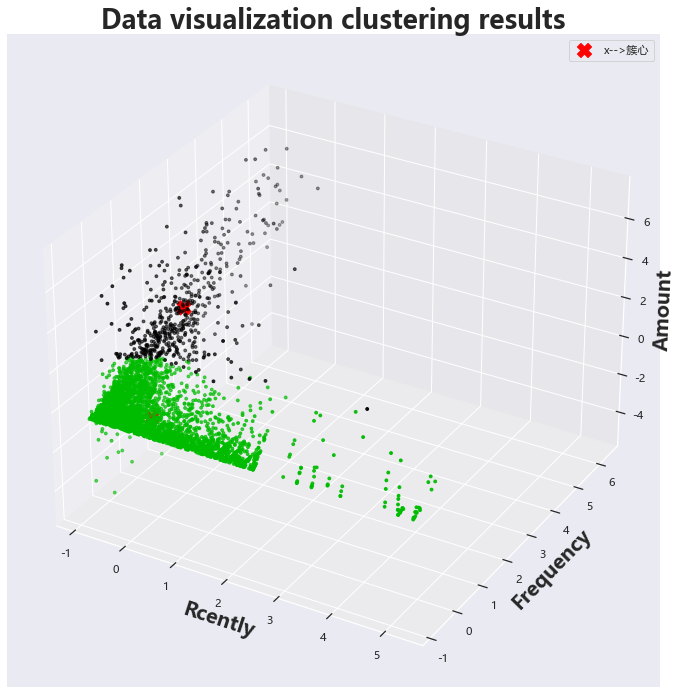

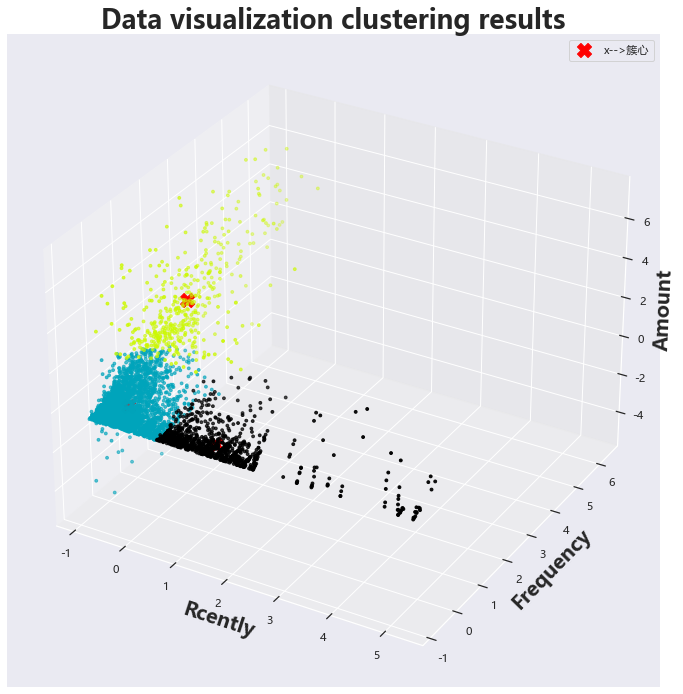

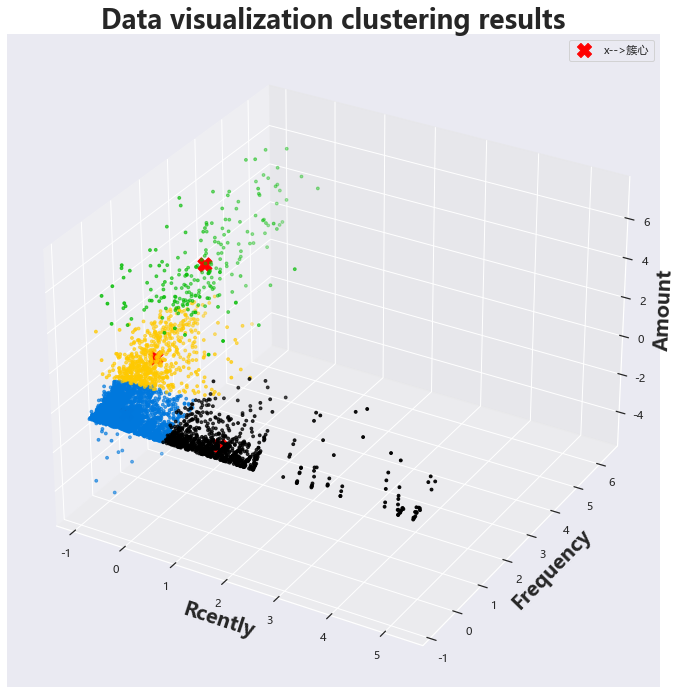

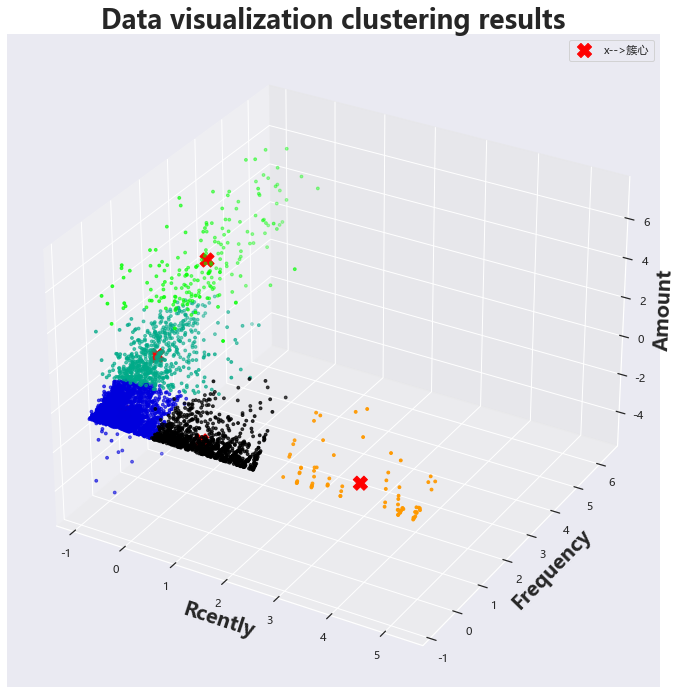

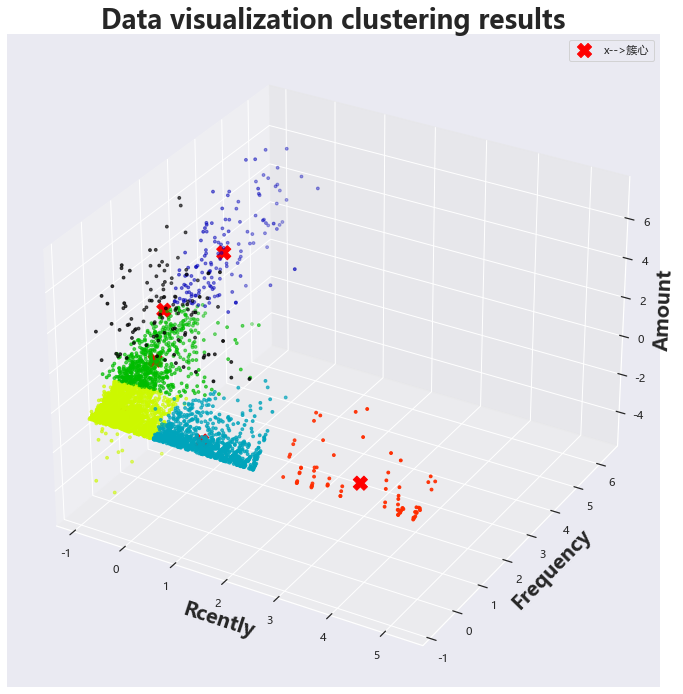

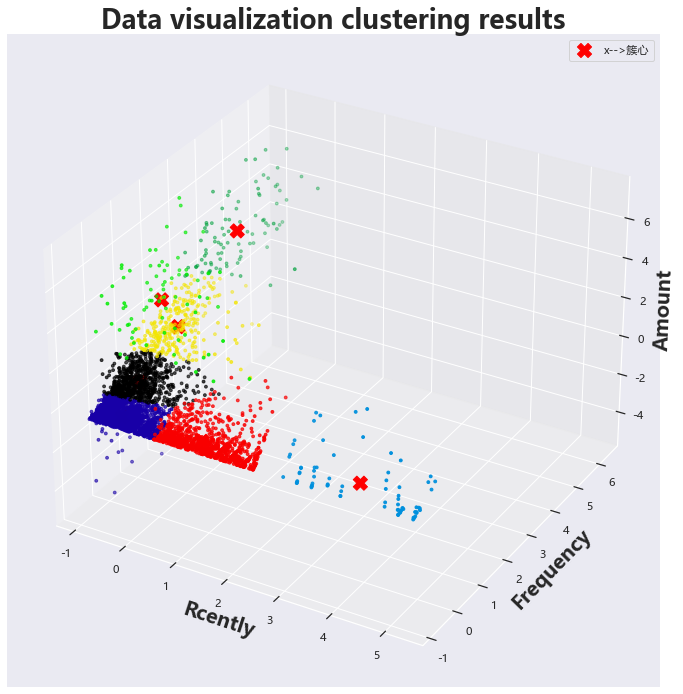

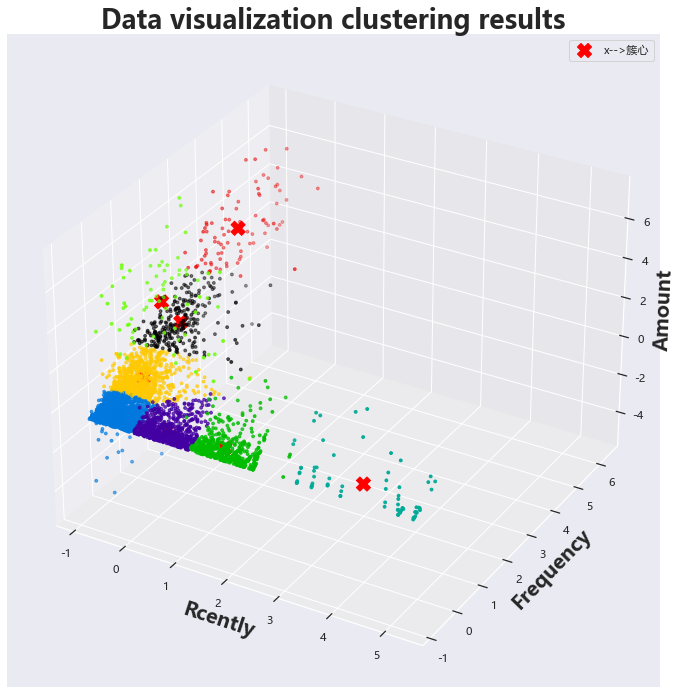

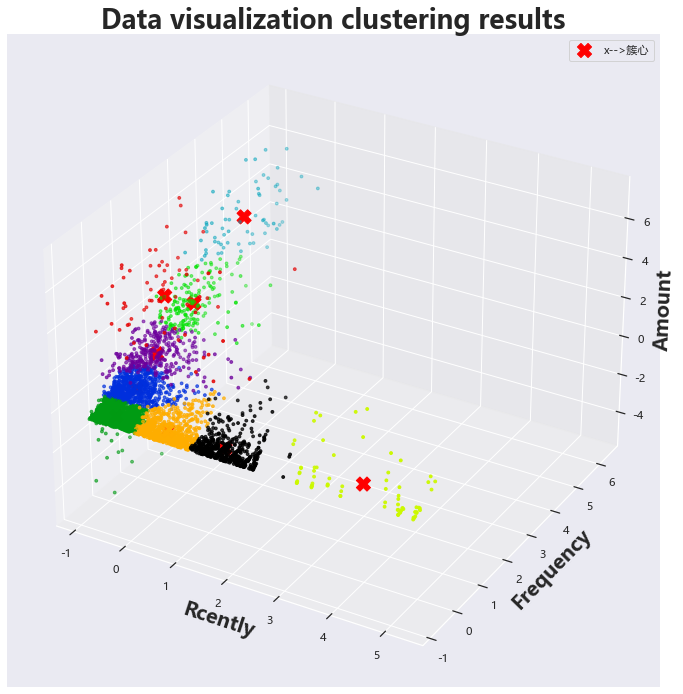

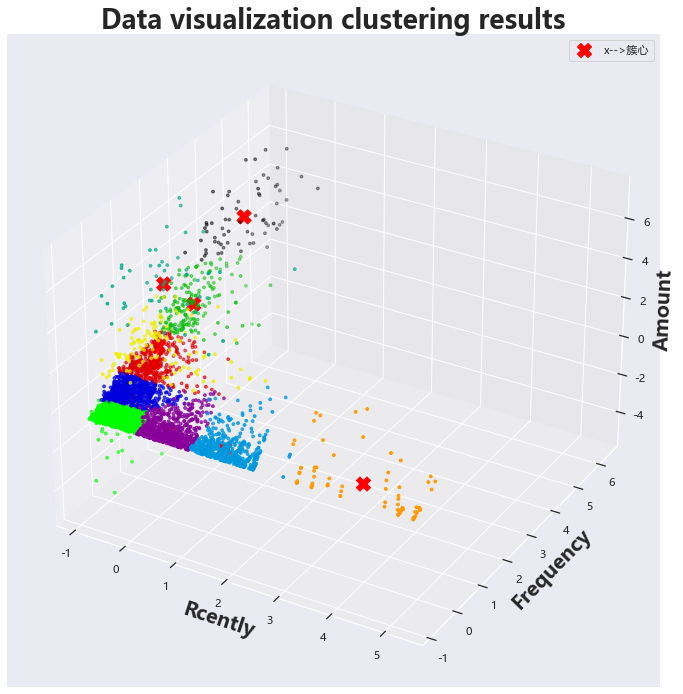

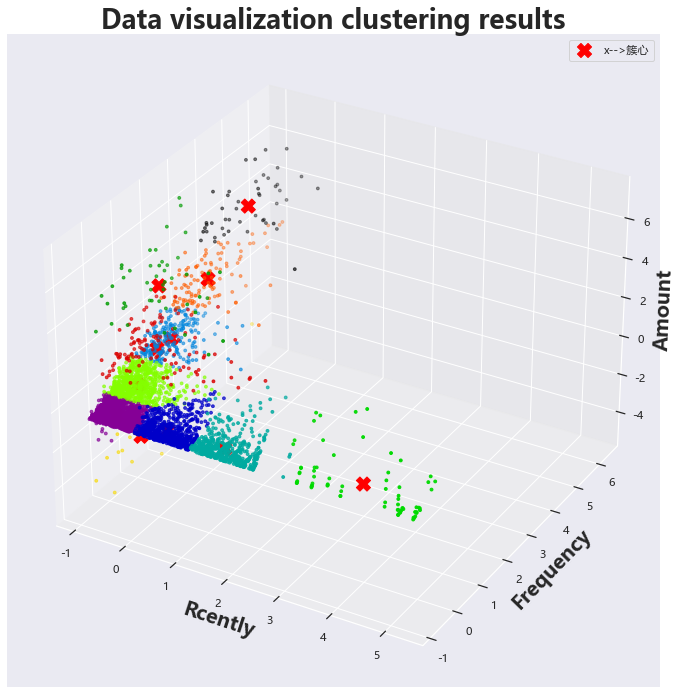

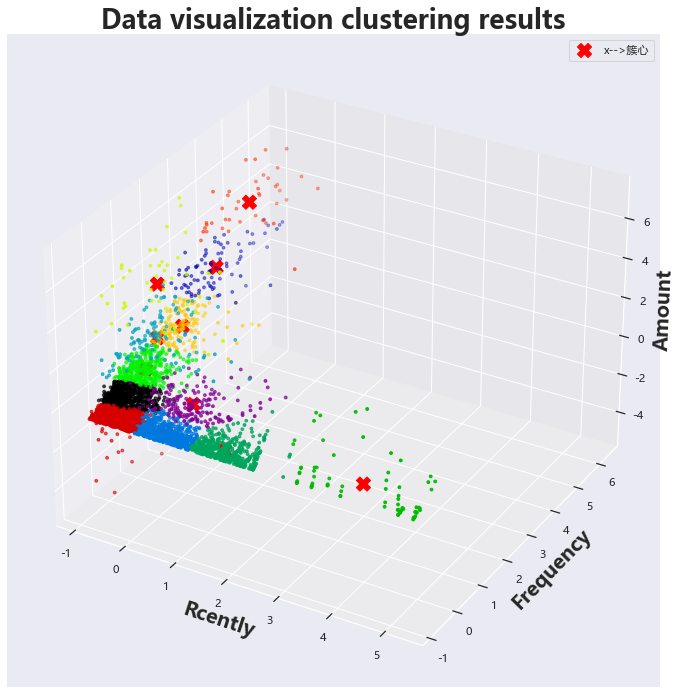

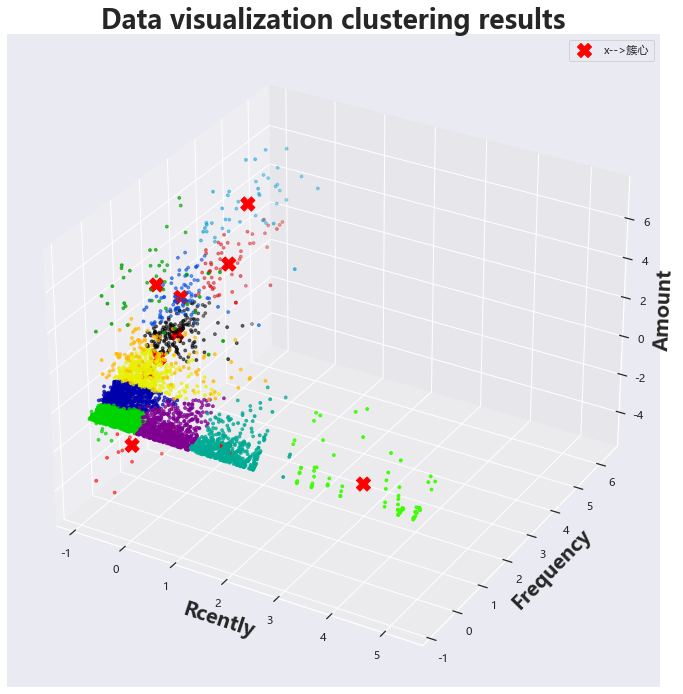

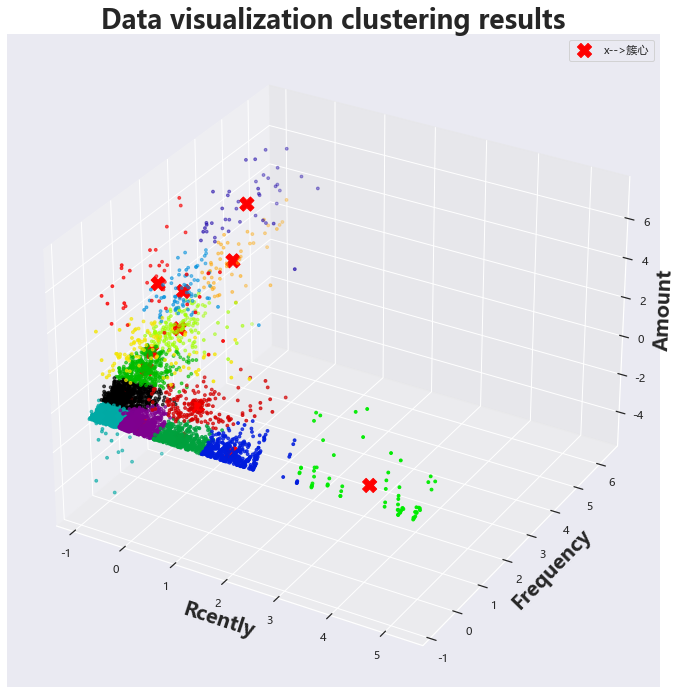

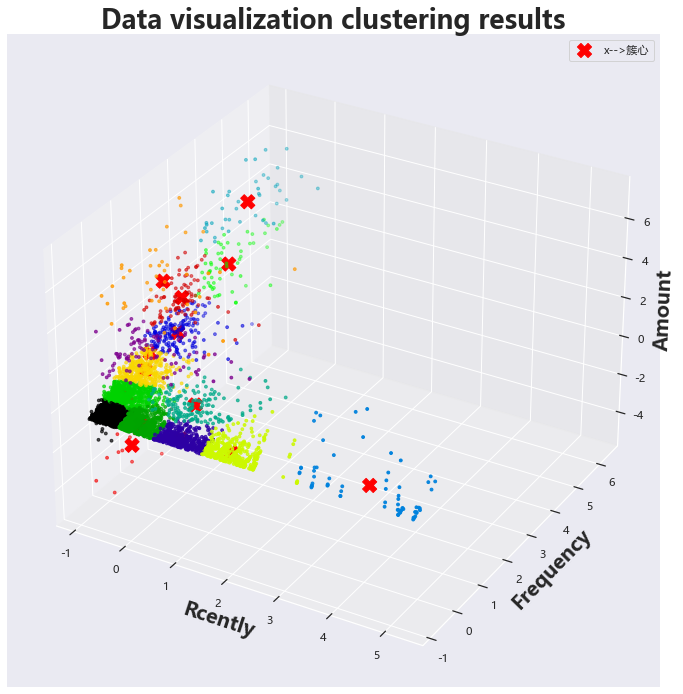

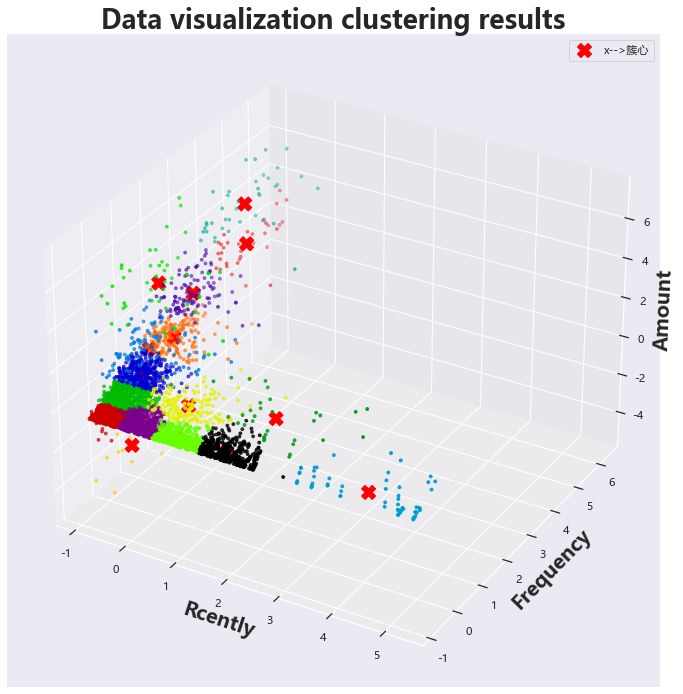

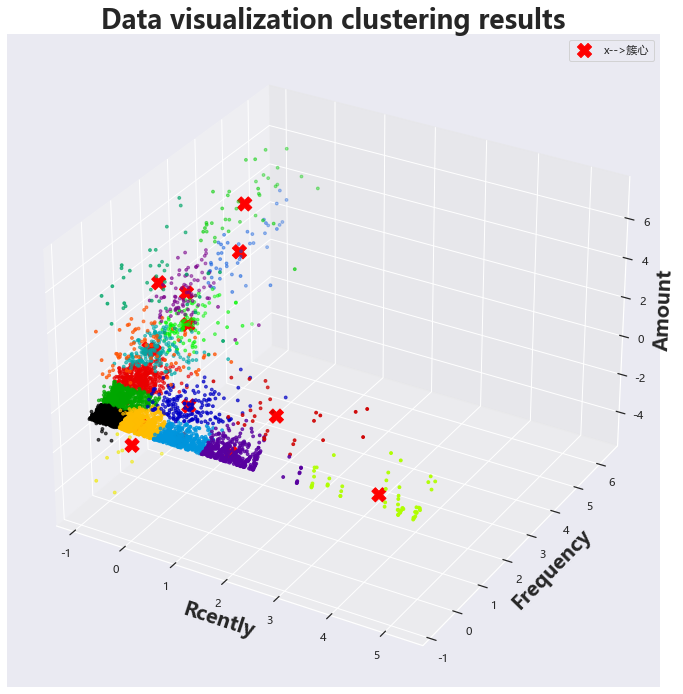

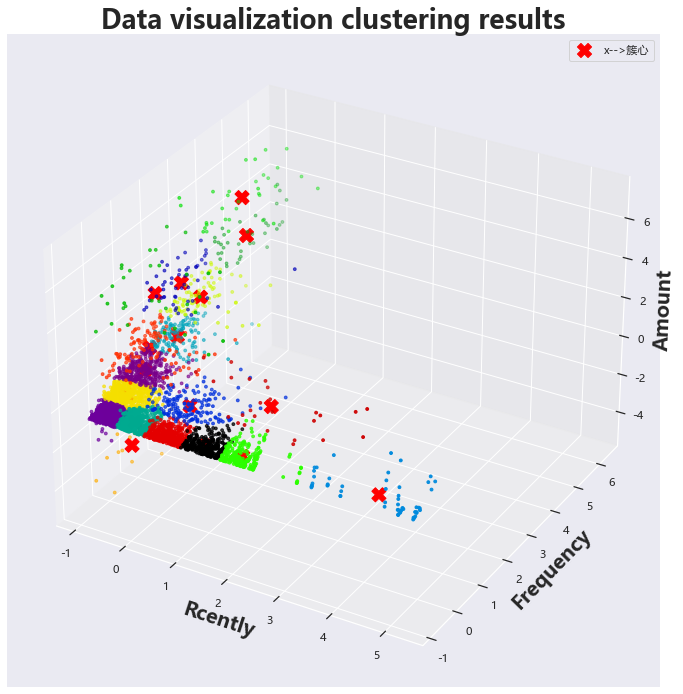

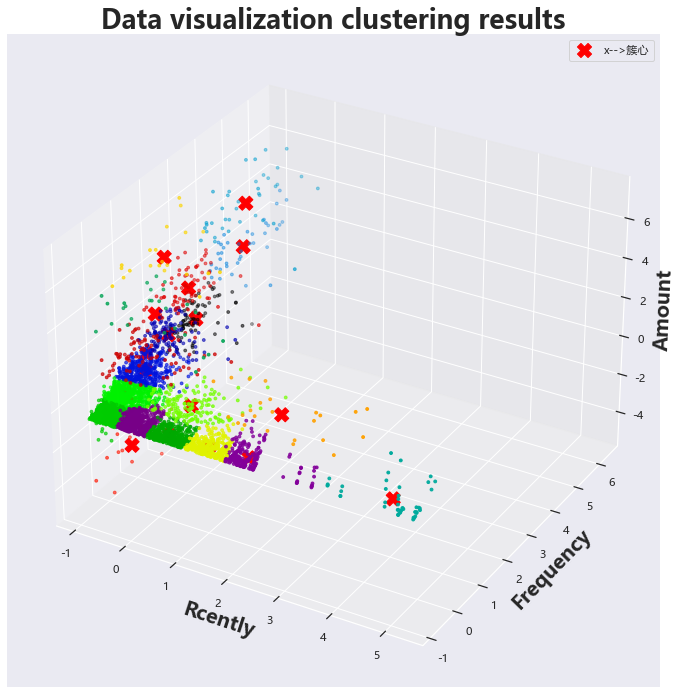

In [238]:

X = train
n_clusters_score = []
for n_clusters in range(2,20,1):
      n_clusters = n_clusters
      fig = plt.figure(figsize=(12,12))

      ax = fig.add_subplot(1,1,1,projection='3d')
      clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
      cluster_labels = clusterer.labels_
      centerer = clusterer.cluster_centers_

      data_train = pd.DataFrame(train,columns=['R','F','M'])
      data_label = pd.DataFrame(clusterer.labels_,columns=['聚类类别'])
      RFM_C = pd.merge( data_train,
                        data_label,
                        left_index=True,
                        right_index=True
                        )
      silhouette_avg = silhouette_score(X, cluster_labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg) 
      n_clusters_score.append(silhouette_avg)

      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      # 画出簇心
      ax.scatter(centerer[:, 0], centerer[:, 1],centerer[:, 2], marker='X',
                  c="red", alpha=1, s=200,label='x-->簇心')
      # 画出散点图
      ax.scatter(RFM_C['R'], RFM_C['F'], RFM_C['M'],marker='o',s=8,c=colors)
      ax.set_xlabel('Rcently',fontsize=20,fontweight='bold') 
      ax.set_ylabel('Frequency',fontsize=20,fontweight='bold')
      ax.set_zlabel('Amount',fontsize=20,fontweight='bold')
      ax.set_title('Data visualization clustering results',fontsize=26,fontweight='bold')
      ax.legend();


### n_clusters曲线

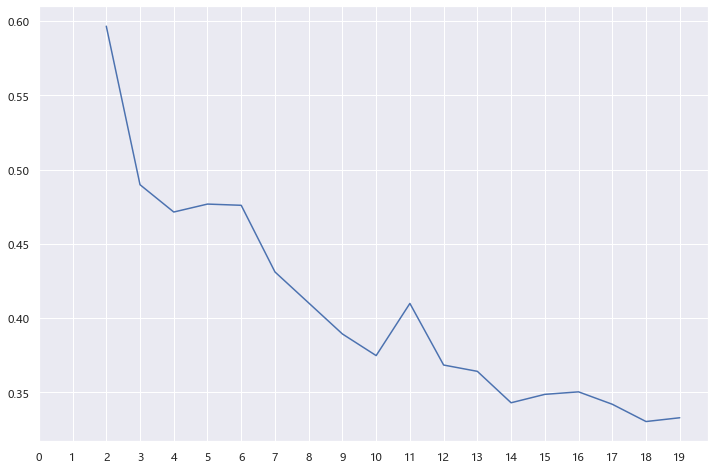

In [252]:
plt.plot(range(2,20),n_clusters_score)
plt.xticks(np.arange(0,20,step=1));
"""
下图可以看到，参数n_clusters越大，聚类效果越差；
所以理论上来说，参数n_clusters=2时，聚类效果最好；
然而实际业务有固定需求，比如RFM模型需要分为8类，从图上
可以看到当n_clusters=8时，聚类效果并不是最好的，甚至不如n_clusters=11类时的效果；
基于理论分数和实际业务划分综合考虑，我会推荐将用户划分为5类时聚类模型会更加精确，实现精准营销策略
""";